# ClickHouse vs Exasol

Материал подготовлен на основе ноутбука Евгения Кудашева

Ссылка на оригинальные расчеты https://github.com/eugeneks/aha_2021/blob/main/aha_2021.ipynb

Цель работы: повторить расчеты автора, по возможности задействовав функциональность БД ClickHouse

In [1]:
import pandas as pd
import numpy as np
import os
import time
import requests
import copy

## Демонстрационный датасет

In [2]:
DATASET_DIR = './example_data/'
DATASET_NAME = 'online-retail.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/eugeneks/aha_2021/main/online-retail.csv'

In [3]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 21 µs, sys: 6 µs, total: 27 µs
Wall time: 31.2 µs


In [4]:
data = pd.read_csv(DATASET_FULLNAME,parse_dates=['InvoiceDate'])

In [5]:
data.columns = [_.lower() for _ in data.columns]

In [6]:
data.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   406829 non-null  float64       
 7   country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df = copy.deepcopy(data)

In [9]:
df['customerid'] = df['customerid'].fillna(0)
df['description'] = df['description'].fillna("-")

In [10]:
df = df.astype({'customerid': 'int32','quantity':"int32", 'unitprice':'float32'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  541909 non-null  object        
 3   quantity     541909 non-null  int32         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float32       
 6   customerid   541909 non-null  int32         
 7   country      541909 non-null  object        
dtypes: datetime64[ns](1), float32(1), int32(2), object(4)
memory usage: 26.9+ MB


In [12]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom


## Установка БД ClickHouse

In [13]:
!sudo apt-get install apt-transport-https ca-certificates dirmngr
!sudo apt-key adv --keyserver hkp://keyserver.ubuntu.com:80 --recv E0C56BD4

!echo "deb https://repo.clickhouse.tech/deb/stable/ main/" | sudo tee \
    /etc/apt/sources.list.d/clickhouse.list
!sudo apt-get update

!sudo apt-get install -y clickhouse-server clickhouse-client

!sudo service clickhouse-server start
!clickhouse-client

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ca-certificates is already the newest version (20210119~18.04.1).
dirmngr is already the newest version (2.2.4-1ubuntu1.4).
apt-transport-https is already the newest version (1.6.14).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.
Executing: /tmp/apt-key-gpghome.1aJggbsTHH/gpg.1.sh --keyserver hkp://keyserver.ubuntu.com:80 --recv E0C56BD4
gpg: key C8F1E19FE0C56BD4: "ClickHouse Repository Key <milovidov@yandex-team.ru>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
deb https://repo.clickhouse.tech/deb/stable/ main/
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubun

In [14]:
!pip install clickhouse-driver

In [15]:
from clickhouse_driver import Client
client = Client(host='localhost')
client.execute('SHOW DATABASES')

[('db',), ('default',), ('system',)]

In [16]:
client.execute('DROP DATABASE IF EXISTS db')
client.execute('CREATE DATABASE db')
client.execute('SHOW DATABASES')

[('db',), ('default',), ('system',)]

In [17]:
client = Client(host='localhost', user='default', port='9000', database='db')

In [18]:
client.execute('DROP TABLE IF EXISTS retail')
client.execute('CREATE TABLE retail (invoiceno  String,  \
                                      stockcode String,  \
                                      description String, \
                                      quantity Int32, \
                                      invoicedate Date, \
                                      unitprice Float32, \
                                      customerid Int32, \
                                      country  String \
                                      ) ENGINE = Memory')
client.execute('SHOW TABLES FROM db')

[('retail',)]

In [19]:
client.execute("INSERT INTO retail VALUES", df.to_dict('records'))

541909

In [20]:
def select_clickhouse(sql):
  return client.query_dataframe(sql)

In [21]:
sql = '''SELECT * FROM retail LIMIT 5'''

In [22]:
select_clickhouse(sql)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12,3.39,17850,United Kingdom


## Общая статистика

### Pandas

In [23]:
df.describe()

,quantity,unitprice,customerid
count,541909.000000,541909.000000,541909.000000
mean,9.552250,4.616765,11476.974671
std,218.081158,96.714073,6777.908326
min,-80995.000000,-11062.059570,0.000000
25%,1.000000,1.250000,12352.000000
50%,3.000000,2.080000,14382.000000
75%,10.000000,4.130000,16255.000000
max,80995.000000,38970.000000,18287.000000


### SQL

In [24]:
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype

In [25]:
table_name = 'retail'

sql = ""

df_col_is_numeric = [_ for _ in df.columns if is_numeric_dtype(df[_])]


for col in df_col_is_numeric:
  sql_tmpl = f"""
          SELECT
            '{col}' AS col_name,
            COUNT(*) AS cnt,
            COUNT(DISTINCT {col}) AS cnt_distinct, 
            SUM(IF({col},0,1)) AS is_null_cnt,
            CEIL(MIN({col}),1) AS min_value,
            CEIL(AVG({col}),1) AS avg_value,
            CEIL(MAX({col}),1) AS max_value     
          FROM
             {table_name}
     """
  if sql == "":
    sql = sql_tmpl
  else:
    sql = sql + """
    
    UNION ALL
    
    """ + sql_tmpl
    
print(sql)



          SELECT
            'quantity' AS col_name,
            COUNT(*) AS cnt,
            COUNT(DISTINCT quantity) AS cnt_distinct, 
            SUM(IF(quantity,0,1)) AS is_null_cnt,
            CEIL(MIN(quantity),1) AS min_value,
            CEIL(AVG(quantity),1) AS avg_value,
            CEIL(MAX(quantity),1) AS max_value     
          FROM
             retail
     
    
    UNION ALL
    
    
          SELECT
            'unitprice' AS col_name,
            COUNT(*) AS cnt,
            COUNT(DISTINCT unitprice) AS cnt_distinct, 
            SUM(IF(unitprice,0,1)) AS is_null_cnt,
            CEIL(MIN(unitprice),1) AS min_value,
            CEIL(AVG(unitprice),1) AS avg_value,
            CEIL(MAX(unitprice),1) AS max_value     
          FROM
             retail
     
    
    UNION ALL
    
    
          SELECT
            'customerid' AS col_name,
            COUNT(*) AS cnt,
            COUNT(DISTINCT customerid) AS cnt_distinct, 
            SUM(IF(customerid,0,1)) AS is_

In [26]:
select_clickhouse(sql)

,col_name,cnt,cnt_distinct,is_null_cnt,min_value,avg_value,max_value
0,quantity,541909,722,0,-80995.0,9.6,80995.0
1,unitprice,541909,1629,2519,-11062.0,4.7,38970.0
2,customerid,541909,4373,135080,0.0,11477.0,18287.0


## Перцентильный анализ

In [27]:
# client.execute('set allow_experimental_window_functions = 1;')

In [28]:
sql = """WITH retail_percentile_base as (SELECT DATE_TRUNC('quarter', r.invoicedate) AS quarter,
                              r.customerid as customer,
                             SUM(r.quantity*r.unitprice) as amount,
                             COUNT(DISTINCT invoiceno) as sales_cnt
                            FROM retail as r 
                            GROUP BY DATE_TRUNC('quarter', r.invoicedate ), r.customerid),
                            
            tbl as   (SELECT rp.quarter, count(*) as count
                      FROM retail_percentile_base as rp GROUP BY rp.quarter),

            ranked_q1 as (SELECT rp.customer,
                                 rp.amount AS amount_q1,
                                rank() OVER (ORDER BY rp.amount DESC) AS rnk_q1,
                                COUNT(DISTINCT rp.customer) OVER() AS cnt_q1,
                                rp.sales_cnt AS sales_cnt_q1
                          FROM 
                                retail_percentile_base as rp
                          WHERE 
                                rp.quarter = '2011-04-01'),

              ranked_q2 as (SELECT rp.customer,
                                 rp.amount AS amount_q2,
                                rank() OVER (ORDER BY rp.amount DESC) AS rnk_q2,
                                COUNT(DISTINCT rp.customer) OVER() AS cnt_q2,
                                rp.sales_cnt AS sales_cnt_q2
                          FROM 
                                retail_percentile_base as rp
                          WHERE 
                                rp.quarter = '2011-07-01'),

              result as ( SELECT 
                  COALESCE(r2.customer, r1.customer) AS customer,
                  COALESCE(r2.amount_q2, 0) AS amount_q2,
                  COALESCE(r1.amount_q1, 0) AS amout_q1,
                  COALESCE(r2.sales_cnt_q2,0) AS sales_cnt_q2,
                  COALESCE(r1.sales_cnt_q1,0) AS sales_cnt_q1,
                  COALESCE(1- r2.rnk_q2/r2.cnt_q2, 0) AS prcentile_q2,
                  COALESCE(1- r1.rnk_q1/r1.cnt_q1, 0) AS prcentile_q1,
  IF (COALESCE(amount_q2, 0) > COALESCE(amount_q1, 0), 'Growth','Fall')AS color
                         FROM
                              ranked_q2 as r2  FULL JOIN ranked_q1 as r1
                         ON  r2.customer = r1.customer)


            SELECT *
            FROM result"""

In [29]:
df_percentile = select_clickhouse(sql)

In [30]:
df_percentile.head()

,customer,amount_q2,amout_q1,sales_cnt_q2,sales_cnt_q1,prcentile_q2,prcentile_q1,color
0,0,361369.619706,214366.758323,888,892,0.999570,0.999538,Growth
1,18102,100824.358923,63547.089818,24,20,0.999141,0.999076,Growth
2,17450,94540.460311,27136.080114,21,10,0.998711,0.996303,Growth
3,14646,59445.569861,34789.580033,20,14,0.998281,0.997689,Growth
4,14911,46326.379794,17558.579911,86,45,0.997851,0.994455,Growth


### Визуализация результатов

In [31]:
import matplotlib.pyplot as plt
import matplotlib.style as style

import seaborn as sns
%matplotlib inline

style.use('fivethirtyeight')


Text(0.5, 1, 'ABC segments ')

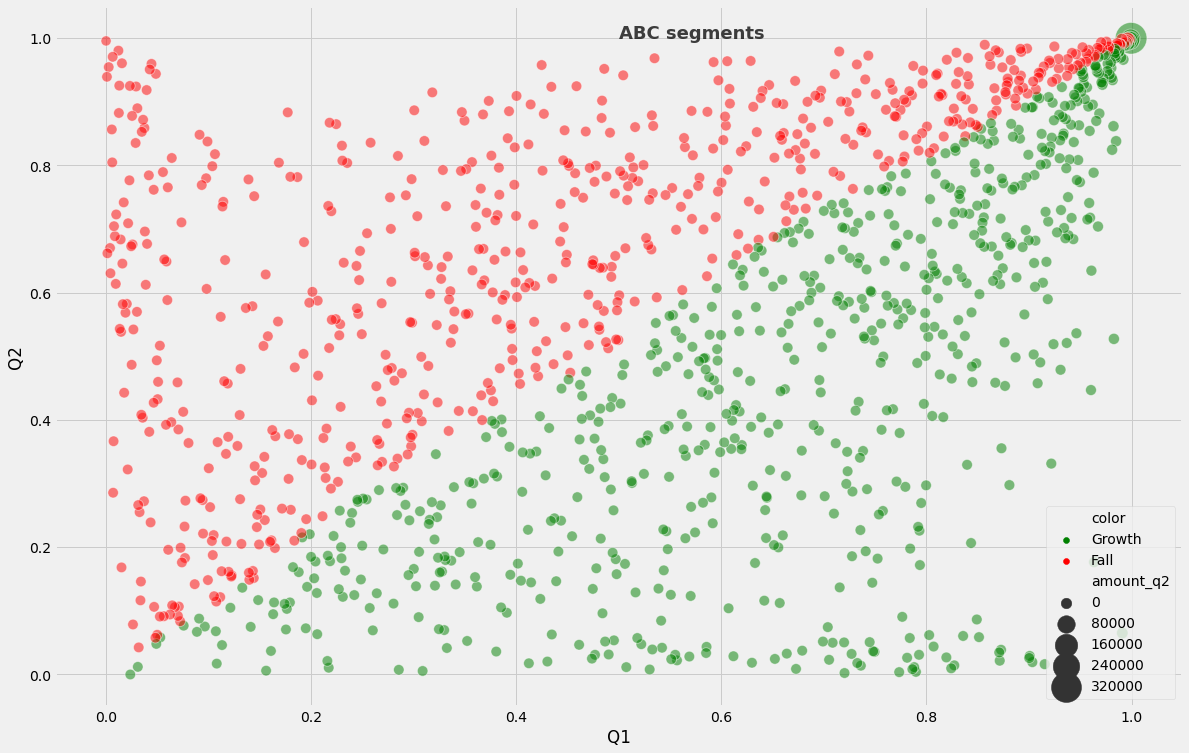

In [32]:
color_dict = {'Growth':'green',
              'Fall':'red',
}

g = sns.scatterplot(x="prcentile_q2", y="prcentile_q1",
              hue="color",
              palette=color_dict, 
              alpha = 0.5,
              legend='brief',
              size= 'amount_q2',
              sizes=(100, 1000),
              data=df_percentile)
              
              
plt.xlabel("Q1")
plt.ylabel("Q2")
plt.legend(loc = 'best')


F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*3, Size[1]*3, forward=True) 

plt.text(x = 0.5, y = 1, s = "ABC segments ",
               fontsize = 18, weight = 'bold', alpha = .75)

## RFM сегментация

In [33]:
sql = """
  WITH  current_day as   (
          SELECT MAX(r.invoicedate) + INTERVAL '1' DAY AS day 
                FROM retail as r),
  
        retail_orders AS (
          SELECT
                r.invoiceno AS order_id,
                r.invoicedate AS order_date,
                r.customerid AS customer,
                SUM(r.quantity*r.unitprice) AS amount,
                MAX(d.day) as today
          FROM 
                retail as r cross join current_day as d
          GROUP BY
                r.invoiceno,
                r.invoicedate,
                r.customerid
         HAVING 
               SUM(r.quantity*r.unitprice) >0),
                  
       base AS (
          SELECT 
               ro.customer,
               MIN(dateDiff('day', ro.order_date,ro.today)) AS recency,
               COUNT(DISTINCT ro.order_id) AS frequency,
               ceil(SUM(ro.amount),2) AS monetary
         FROM
              retail_orders AS ro
        GROUP BY 
              ro.customer
        HAVING 
             ro.customer <> 0),

      bins AS (
            SELECT
              MIN(b.recency) As r_min,
              quantile(0.2) (b.recency) AS r_20,
              quantile(0.4) (b.recency) AS r_40,
              quantile(0.6) (b.recency) AS r_60,
              quantile(0.8) (b.recency) AS r_80,
             MAX(b.recency) AS r_max,

              MIN(b.frequency) As f_min,
              quantile(0.2) (b.frequency) AS f_20,
              quantile(0.4) (b.frequency) AS f_40,
              quantile(0.6) (b.frequency) AS f_60,
              quantile(0.8) (b.frequency) AS f_80,
             MAX(b.frequency) AS f_max,

              MIN(b.monetary) As m_min,
              quantile(0.2) (b.monetary) AS m_20,
              quantile(0.4) (b.monetary) AS m_40,
              quantile(0.6) (b.monetary) AS m_60,
              quantile(0.8) (b.monetary) AS m_80,
             MAX(b.monetary) AS m_max

            FROM  base as b),

      rfm AS (
            SELECT
             customer,
             recency,
             frequency,
             monetary,
            CASE 
                WHEN recency <= r_20 THEN 5
                WHEN recency <= r_40 THEN 4
                WHEN recency <= r_60 THEN 3
                WHEN recency <= r_80 THEN 2
                ELSE 1
            END AS r,
            CASE 
               WHEN frequency <= f_20 THEN 1
               WHEN frequency <= f_40 THEN 2
               WHEN frequency <= f_60 THEN 3
               WHEN frequency <= f_80 THEN 4
                ELSE 5
            END AS f,
            CASE 
              WHEN monetary <= m_20 THEN 1
              WHEN monetary <= m_40 THEN 2
              WHEN monetary <= m_60 THEN 3
              WHEN monetary <= m_80 THEN 4
              ELSE 5
             END AS m,
            r_min,
            r_max,
            f_min,
            f_max,
            m_min,
            m_max
         FROM base CROSS JOIN  bins),

         seg_map AS (
     SELECT '11,12,21,22' AS segKey, 'hibernating' AS segValue
       UNION ALL
     SELECT '13,14,23,24' AS segKey, 'at risk' AS segValue 
      UNION ALL
     SELECT '15,25'  AS segKey, 'can not loose'  AS segValue
       UNION ALL
     SELECT '31,32' AS segKey, 'about to sleep' AS segValue
       UNION ALL
     SELECT '33' AS segKey, 'need attention' AS segValue
       UNION ALL
     SELECT '34,35,44,45' AS segKey, 'loyal customers' AS segValue
       UNION ALL
     SELECT '41' AS segKey, 'promising' AS segValue
       UNION ALL
     SELECT '51' AS segKey, 'new customers' AS segValue
       UNION ALL
     SELECT '42,43,52,53' AS segKey, 'potential loyalists' AS segValue
       UNION ALL
     SELECT '54,55' AS segKey, 'champions' AS segValue
        ),

    result_ as (SELECT
        rfm.*, 
        concat(cast(r as text),cast (f as text),cast(m as text)) AS rfm_score, 
        concat(cast(r as text),cast (f as text)) as rf
     FROM rfm),

    result as (SELECT
        r.*, sm.segValue  AS segment
     FROM 
           result_ as r CROSS JOIN seg_map as sm
      WHERE 
            position(sm.segKey, cast(r.rf as TEXT))<>0
       ORDER BY 
         r.customer)

    SELECT *
    FROM result
"""

In [34]:
select_clickhouse(sql)

,customer,recency,frequency,monetary,r,f,m,r_min,r_max,f_min,f_max,m_min,m_max,rfm_score,rf,segment
0,12346,327,1,77183.60,1,1,5,1,698,1,209,3.75,280206.02,115,11,hibernating
1,12347,41,7,4310.00,4,5,5,1,698,1,209,3.75,280206.02,455,45,loyal customers
2,12348,77,4,1797.24,3,4,4,1,698,1,209,3.75,280206.02,344,34,loyal customers
3,12349,20,1,1757.55,4,1,4,1,698,1,209,3.75,280206.02,414,41,promising
4,12350,312,1,334.40,1,1,2,1,698,1,209,3.75,280206.02,112,11,hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18280,161,1,180.60,2,1,1,1,698,1,209,3.75,280206.02,211,21,hibernating
4334,18281,5,1,80.83,5,1,1,1,698,1,209,3.75,280206.02,511,51,new customers
4335,18282,217,2,178.05,1,2,1,1,698,1,209,3.75,280206.02,121,12,hibernating
4336,18283,11,16,2094.88,5,5,5,1,698,1,209,3.75,280206.02,555,55,champions


In [35]:
df_rfm = select_clickhouse(sql)

In [36]:
df_rfm.head()

,customer,recency,frequency,monetary,r,f,m,r_min,r_max,f_min,f_max,m_min,m_max,rfm_score,rf,segment
0,12346,327,1,77183.60,1,1,5,1,698,1,209,3.75,280206.02,115,11,hibernating
1,12347,41,7,4310.00,4,5,5,1,698,1,209,3.75,280206.02,455,45,loyal customers
2,12348,77,4,1797.24,3,4,4,1,698,1,209,3.75,280206.02,344,34,loyal customers
3,12349,20,1,1757.55,4,1,4,1,698,1,209,3.75,280206.02,414,41,promising
4,12350,312,1,334.40,1,1,2,1,698,1,209,3.75,280206.02,112,11,hibernating


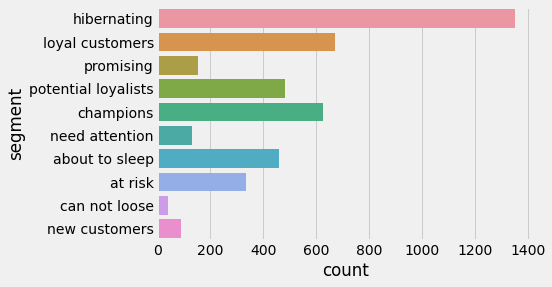

In [37]:
sns.countplot(y='segment',data=df_rfm)

# Статистические тесты

In [47]:
sql = """WITH  base AS  (
                      SELECT r.country as country,
                             r.invoiceno as invoiceno,
                            SUM(r.quantity*r.unitprice) AS amount
                      FROM retail as r
                      WHERE 
                      (r.country IN ('Germany','France')) AND (r.customerid<>0)
                      GROUP BY r.country, r.invoiceno
                      HAVING SUM(r.quantity*r.unitprice) >0),
          base_stats as ( SELECT
                              b.country,
                              avg(b.amount) AS mean,
                              stddevSamp(b.amount) AS std,
                              varSamp(b.amount) AS var,
                              COUNT(*) AS count
                           FROM base as b
                          GROUP BY b.country)

           SELECT bs.*
           FROM base_stats as bs"""

In [48]:
select_clickhouse(sql)

,country,mean,std,var,count
0,France,537.336887,687.253541,472317.430176,389
1,Germany,500.803367,608.916230,370778.975044,457


In [51]:
sql = """WITH  base AS  (
                      SELECT r.country as country,
                             r.invoiceno as invoiceno,
                            SUM(r.quantity*r.unitprice) AS amount
                      FROM retail as r
                      WHERE 
                      (r.country IN ('Germany','France')) AND (r.customerid<>0)
                      GROUP BY r.country, r.invoiceno
                      HAVING SUM(r.quantity*r.unitprice) >0)

           SELECT b.*
           FROM base as b"""

In [52]:
select_clickhouse(sql)

,country,invoiceno,amount
0,Germany,553842,400.879997
1,France,563189,412.879996
2,Germany,560038,875.279998
3,Germany,546925,464.699993
4,Germany,560230,345.229990
...,...,...,...
841,France,574252,260.480000
842,France,577687,397.720000
843,Germany,571904,89.399999
844,Germany,571328,1697.980000


In [54]:
tbl = select_clickhouse(sql)

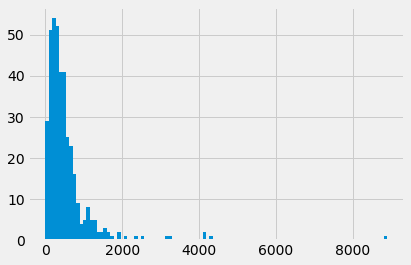

In [59]:
tbl[tbl['country']=='France']['amount'].hist(bins=100)

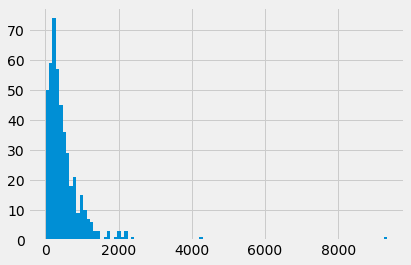

In [60]:
tbl[tbl['country']=='Germany']['amount'].hist(bins=100)

In [61]:
import scipy
import scipy.stats as stats
from scipy.stats import wilcoxon, mannwhitneyu,f_oneway

### Проверка на нормальность данных

In [63]:
# Тест Шапиро-Уилка
x1 = tbl[tbl['country']=='France']['amount']
stat, p = stats.shapiro(x1)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.520, p-value=0.000
Отклонить гипотезу о нормальности


### U-критерий Манна — Уитни (Python)

In [99]:
A = tbl[tbl['country']=='France']['amount']
B = tbl[tbl['country']=='Germany']['amount']
stat, p = mannwhitneyu(A, B,alternative="two-sided")
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

Statistics=92148.500, p=0.357
Различий в эффекте нет


### U-критерий Манна — Уитни (ClickHouse)

In [112]:
sql = """WITH  base AS  (
                      SELECT r.country as country,
                             r.invoiceno as invoiceno,
                            SUM(r.quantity*r.unitprice) AS amount          
                      FROM retail as r
                      WHERE 
                      (r.country IN ('Germany','France')) AND (r.customerid<>0)
                      GROUP BY r.country, r.invoiceno
                      HAVING SUM(r.quantity*r.unitprice) >0),

            base_test as (
              SELECT b.amount as amount, 
                     b.country =='Germany'?0:1 as index
              FROM base as b
            )
  SELECT mannWhitneyUTest('two-sided')(bt.amount, bt.index)  as mannWhitneyUTest
  FROM base_test as bt"""

In [113]:
select_clickhouse(sql)

,mannWhitneyUTest
0,"(85624.5, 0.35719015853288494)"
